<b>Data augmentation using Image data generator</b>

In this code we will augment image data using Image datagenerator and then export them as a zipped numpy files
Data Augmentation and Saving Augmented data array for training


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from numpy import load, savez_compressed
import gc


def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

data_FULL_training = unpickle(r'../input/trimagi/training_x.dat') #Loads all unpickled raw data in datadict variable
Label_FULL_training = unpickle(r'../input/trimagi/training_y.dat') #Loads all unpickled raw data in datadict variable

data_Validation = unpickle(r'../input/trimagi/validation_x.dat') #Loads all unpickled raw Test data in datadict_tst variable


cuML version 21.10.02


In [2]:
def Val_Processing(validation_list):
    
    validation_list=np.array(validation_list)
    validation_list=validation_list[:,:,:,0]
    validation_list = validation_list.reshape(validation_list.shape[0], validation_list.shape[1]*validation_list.shape[2])
           
    return validation_list

VALIDATION_TST = Val_Processing(data_Validation)

VALIDATION_TST = (VALIDATION_TST - np.min(VALIDATION_TST)) / (np.max(VALIDATION_TST) - np.min(VALIDATION_TST))

print("Validation Dataset's Dimensions:" ,VALIDATION_TST.shape)

del data_Validation
gc.collect()

Validation Dataset's Dimensions: (48238, 64)


45

In [3]:
def DATA_Processing2(data_list,class_list):
    
    #Remove unformatted data
    remove_idx=[]
    for i in range(1,len(data_list)):
        if data_list[i].shape[0]!=8 or data_list[i].shape[1]!=8 or data_list[i].shape[2]!=3:
            #print(i)
            #print(data_list[i].shape)  
            remove_idx.append(i)

    for j in range(len(remove_idx)):    
        print("Removing value at index",remove_idx[j]) 
        remove=data_list.pop(remove_idx[j])
        remove=class_list.pop(remove_idx[j])


    data_list=np.array(data_list) 
    class_list=np.array(class_list)
    
    
    #8x8 image FILTERED TO 64 BIT vector
    data_list=data_list[:,:,:,0]

    #data_list = data_list.reshape(data_list.shape[0], data_list.shape[1]*data_list.shape[2])
    
    #print(data_list[0])

    return data_list,class_list

X_original,Y_original = DATA_Processing2(data_FULL_training,Label_FULL_training)

X_original = X_original.reshape(X_original.shape[0], X_original.shape[1]*X_original.shape[2])

smote = SMOTE(sampling_strategy='auto')
X_original, Y_original = smote.fit_resample(X_original, Y_original)

print("Training Dataset's Dimensions:" ,X_original.shape,"class Dim: ", Y_original.shape)

del data_FULL_training
del Label_FULL_training
gc.collect()

Removing value at index 216805
Training Dataset's Dimensions: (1300000, 64) class Dim:  (1300000,)


0

**Image DataGenerator can be used to generate any number of augmentations**

The parameters such as width_shift_range, rotation range, height shift, flip etc.. can be provided to generate augmented images.

datagen.flow takes images and labels in specialised form along with the batch size and shuffle flag.
The Augmented data and lables are appended to lists and then exported as numpy zip fle.
note that this flow creates and infinity loop and will continue to iterate and will require a terminating condition to exit the for loop.

In our case, if the **num_augmented** variable that works as counter becomes equal to the number of total images in our original dataset, then we exit the loop. Since we have already iterated over entire dataset and have created an augmented batch for each image in the dataset, we can exit.

In [4]:
#datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)
#datagen = ImageDataGenerator(width_shift_range=0.1)

#datagen = ImageDataGenerator(rotation_range=10,zoom_range = 0.10,width_shift_range=4, height_shift_range=4)
datagen = ImageDataGenerator(width_shift_range=2, height_shift_range=2,fill_mode="constant") 
#additional flags... ,horizontal_flip=True,vertical_flip=True

augmented_data = []
augmented_Label = []

num_augmented = 0
batch_size = 4  #Each image will create 4 augmented images so, augmented data will be 4 times original data

for X_batch, y_batch in datagen.flow(X_original.reshape((-1,8,8,1)), Y_original.reshape((-1,1)), batch_size=batch_size, shuffle=False):
    augmented_data.append(X_batch)
    augmented_Label.append(y_batch)
    
    #num_augmented += batch_size
    num_augmented += 1
    
    if (num_augmented % 50000 == 0): print(num_augmented)  #Only used to track how many images in dataset have been augmented.
    if num_augmented == X_original.shape[0]:   #Breaking condition
        break
X = np.concatenate(augmented_data).astype("uint8")  #Change data type to uint8 for ease of storage and list to np array
X = X[:,:,:,0]                                      #Store only single channel
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])  #Reshape

Y = np.concatenate(augmented_Label).flatten().astype("uint8") 

X = np.concatenate((X_original,X))   #Concatinate original data to agumneted data
Y = np.concatenate((Y_original,Y))


print()
print("Data Shape: ",X.shape," Label Shape:",Y.shape)

##To Save file
savez_compressed('New_Y.npz', Y)  #Save as compressed numpy zip files.
savez_compressed('New_X.npz', X)

del augmented_data
del augmented_Label
gc.collect()

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000
1250000
1300000

Data Shape:  (6500000, 64)  Label Shape: (6500000,)


0

**Test it out by Loading and visualizing**

In [5]:
# load dict of arrays
dict_data_X = load('../input/new-xy-aug-01/New_X.npz')
dict_data_Y = load('../input/new-xy-aug-01/New_Y.npz')
# extract the first array
X = dict_data_X['arr_0']
Y = dict_data_Y['arr_0']
# print the array
print("Training Dataset's Dimensions:" ,X.shape,"class Dim: ", Y.shape)
print()

del dict_data_X
del dict_data_Y
gc.collect()

Training Dataset's Dimensions: (6500000, 64) class Dim:  (6500000,)



39

In [6]:
#Normalize the data since it was stored as uint8

X = (X - np.min(X)) / (np.max(X) - np.min(X))
X = np.array(X).astype(np.float32)  
Y = np.array(Y).astype(np.float32) 
gc.collect()

23

In [7]:
#Print a sample image

X[0]

array([0.39215687, 0.3764706 , 0.39607844, 0.4392157 , 0.41960785,
       0.38431373, 0.3764706 , 0.39215687, 0.39215687, 0.35686275,
       0.40784314, 0.44313726, 0.43137255, 0.40392157, 0.44313726,
       0.39607844, 0.3764706 , 0.39607844, 0.42352942, 0.52156866,
       0.5568628 , 0.50980395, 0.5294118 , 0.47058824, 0.6313726 ,
       0.627451  , 0.5686275 , 0.5803922 , 0.54901963, 0.5529412 ,
       0.49411765, 0.45882353, 0.7490196 , 0.7372549 , 0.6431373 ,
       0.63529414, 0.5372549 , 0.44313726, 0.44313726, 0.38431373,
       0.4862745 , 0.44313726, 0.42745098, 0.41960785, 0.29803923,
       0.1764706 , 0.27450982, 0.40784314, 0.49019608, 0.4745098 ,
       0.54509807, 0.4745098 , 0.4       , 0.42745098, 0.5176471 ,
       0.56078434, 0.73333335, 0.7372549 , 0.7372549 , 0.68235296,
       0.7411765 , 0.7058824 , 0.5686275 , 0.5058824 ], dtype=float32)

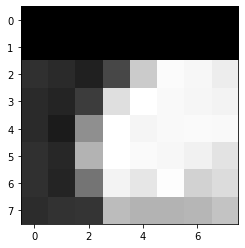

In [8]:
#Plot a sample image

plt.figure(1);
plt.clf()
plt.imshow(X[2801180].reshape((8,8)), cmap='gray')
plt.pause(1)